# NUSTAR SCIENTIFIC PRODUCTS EXTRACTION

This notebook contains the set of cells which extract the NUSTAR scientific products from the raw data and prepares the data for further analysis (not phase-resolved  spectroscopy).

-------

First, import necessary classes and functions from `nustar_scripts` folder in the root

In [1]:
import sys
sys.path.append('../../')
from nustar_scripts.nu_class import np, plt, os, glob, NustarObservation
import matplotlib
from nustar_scripts.pulsar_init import Nu_path, ObsList_bright, ObsList


In [2]:
print(ObsList)

['90302319002', '90302319004', '90302319006', '90302319008', '90401308002', '90401334002', '90501310002']


------

## Choose the  ObsID you want to work with 

by setting ``` ObsID=ObsList[<index>] ```  or by  setting it by  your value, e.g.   ```ObsID = '90201041002'```

I  advice that you create a seperate notebook for each ObsID (by copying this one), so that you can check for  errors or rerun the analysis if necessary for separate observations.

In [5]:
ObsID =  ObsList[0] 
nu_obs = NustarObservation(ObsID, nu_path=Nu_path)

###
Observation 90302319002 loaded successfully


1. Run this cell which creates nupipeline  and  source/background  regions extraction scripts.
2. After the cell finishes, follow instructions one cell below.

In [6]:
#######   nupipeline and regions   #######
nu_obs.nupipeline(ObsList_bright=ObsList_bright)
nu_obs.make_regions()

Exception: nupipeline has already been launched!

3. Run `nupipeline.sh` script in the `out{ObsID}/` directory and wait  until  the nupipeline exits (it may take some time). Check for the errors in nupipeline.
4. Run `ds9_set.sh` sript to set the region files **for both detectors**. Detector `FPMA` would be on the left side of ds9 view, `FPMB` - on the right. Save regions as `srcA.reg`, `srcB.reg`, `bkgA.reg`, and `bkgB.reg` in `out{ObsID}/` folder.
5. Run `ds9_check.sh` script to check the region files - all regions are placed where they should with no interceptions with chip boundaries or misplaced source regin position, etc...

-------

### basic scientific products extraction
extracts spectra and light curves from both modules. 
1. Run the cell and then follow instructions one cell below. 
2. Set parameters as you with (see `nuproducts` method docstring). You may change the energy range of interest, light curve binsize, and a number of other parameters.

In [7]:
prodpath_ave = 'spe_and_lc' #folder name for basic nustar products

os.system('rm -f spe_and_lcA.sh') #remove is exists!
os.system('rm -f spe_and_lcB.sh') #remove is exists!

for mode in ['A', 'B']:      
    nu_obs.nuproducts(outdir=prodpath_ave, mode=mode, stemout=prodpath_ave ,binsize='0.01') #set light curve bin size in seconds and other parameters of interest



Writing to file:  spe_and_lcA.sh
Writing to file:  spe_and_lcB.sh


3. Go to `out{ObsID}/products` directory, run `spe_and_lcA.sh` and `spe_and_lcB.sh` scripts.
4. Go to `out{ObsID}/products/spe_and_lc`, some L1 products should be created and almost prepared for analysis (need to excecute the next cell)

-----

1. Run the code to make scripts for the extraction of barycentred light curves and grouping energy spectra. Set parameters as you with (see functions annotations).

In [8]:
os.system('rm -f barycorr.sh') #remove is exists!
os.system('rm -f grppha.sh') #remove is exists!

lclist = [f'{prodpath_ave}{mode}_sr.lc' for mode in ['A', 'B']]
spelist = [f'{prodpath_ave}{mode}_sr.pha' for mode in ['A', 'B']]

nu_obs.grppha(infiles=spelist,
              prodpath='spe_and_lc', group_min=25) #set minimum grouping of spectra

nu_obs.barycorr(infiles=lclist, prodpath=prodpath_ave, barytime='no')


Writing to file:  grppha.sh
Writing to file:  grppha.sh
Writing to file:  barycorr.sh
Writing to file:  barycorr.sh


2. Run  `grppha.sh` to regroup energy spectra.
3. Run `barycorr.sh` to  make barycentred light curves of the source. 


**Note**: currently no orbit correction is applied to the light curves and event files. This should be fine if the NuSTAR obesrvation duration is short compared to the orbital period. 


**Note**: if your source is bright, the light curves for background should probably be also barycentred and subtracted from the source light curves.


From this moment the spectral data(phase-averaged) is ready to be analysed in XSPEC or similar software.
Light curves may also be analysed and searched for pulsations, periods, QPOs, etc.

------

### Timing analysis: search for pulastions and periods

1.  Run the cell below to produce `lcmath` ftools scripts that sum barycentered light curves from modules FPMA and FPMB and average them.

In [9]:
nu_obs.lcmath(infiles=[x+'_bary' for x in lclist],
              outfile=prodpath_ave+'AB_sr.lc_bary', prodpath=prodpath_ave, cmd_name='lcmath_bary', rewrite=True)


Writing to file:  lcmath_bary.sh


2. Run `lcmath.sh` script in the `out{ObsID}/products/spe_and_lc` directory.

#### Search for orbital period and make pulse profile of the light curve 
 1. Run the cell below to produce `efsearh` ftools script for period finding  with appropriate parameters. See instructions for the `efsearh` script in the heasarc web site.

In [10]:
nu_obs.make_efsearch(prodpath_ave+'AB_sr.lc_bary', prodpath=prodpath_ave, p0='9.8543', dres = '0.00005', nper='32', nphase=16, cmd_name='efsearch_AB', rewrite=True)

Writing to file:  efsearch_AB.sh


2. Run `efsearch_AB.sh` and proceed to the next cell. 


3. Make sure that the period searhing curve is correct and does not contain only noice or multiple peaks. Adjust the  `p0,dres,n_per` arguments to get the best result. 

Print `exit` during viewing efsearh  plot in `/XW` to save the file.

4. Run the next cell to produce the gaussian fit to the period curve to establish period.  Contrary you can  use  the period of maximum chi-squared value of the `efsearch`. In the example we use the former (`9.85425`).

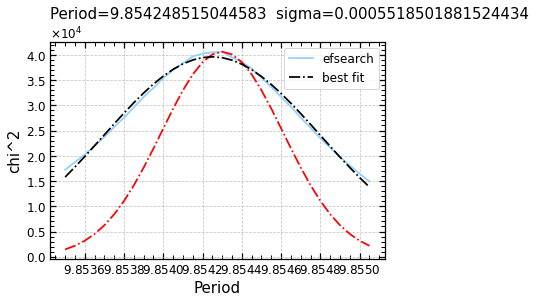

In [11]:
%matplotlib inline
p, perr, p_maxchi = nu_obs.fit_efsearch(filename=prodpath_ave+'AB_sr.lc_bary', 
prodpath=prodpath_ave)
plt.show()

In [12]:
print(f"Period: {p} +/- {perr}; max chi period: {p_maxchi}")

Period: 9.854248515044583 +/- 3.7415821100236775e-06; max chi period: 9.8543


5. Put this value in `periods_val` variable in `pulsar_init.py` file and run the cell below to produce light curve folded with a given period.

In [13]:
from nustar_scripts.pulsar_init import periods_val
period = periods_val[ObsID]
print(f"Period: {period}")

Period: 9.85425


In [14]:
period = periods_val[ObsID]
nu_obs.make_efold(filename = prodpath_ave+'AB_sr.lc_bary', prodpath = prodpath_ave, period = str(period), cmd_name='efold_AB', nphase='128')

Writing to file:  efold_AB.sh


6. Run `efold_AB.sh` script in the `out{ObsID}/products/spe_and_lc` directory  to produce the pulse profile.

7. Run the cell below to produce period-folded light curve.

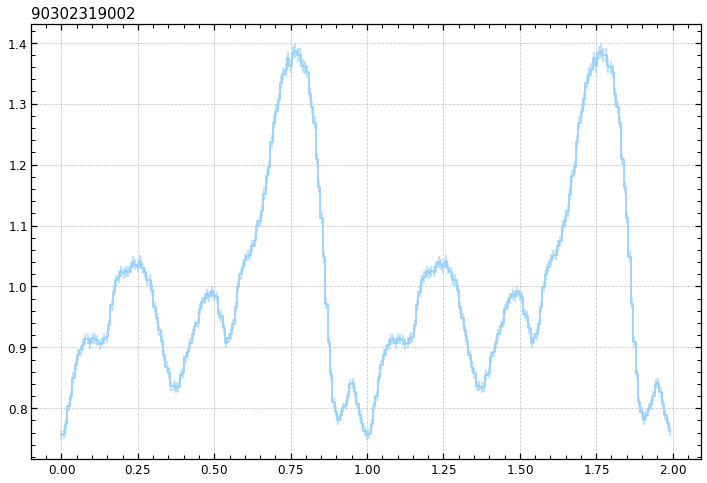

In [15]:
nu_obs.plot_efold(prodpath_ave+'AB_sr.lc_bary_nphase_128', prodpath=prodpath_ave);

-------

The code above produced science products for the observation which is ready for further analysis in **phase-averaged** fashion.

To proceed with the **phase-resolved** analyis, visit `01_ph_resolved.ipynb` notebook.